<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Install useful libraries

In [1]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

Defaulting to user installation because normal site-packages is not writeable
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.1.113 requires chromadb<0.5.0,>=0.4.24, but you have chromadb 0.4.17 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 77.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [2]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()


,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
# PART 1: Initialization

import os
from openai import OpenAI
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# Create a chroma db client
client = chromadb.PersistentClient()

# Get all the reviews in a list
print(f'''The total number of reviews provided are : {len(reviews['Review Text'])}''')
reviews_text = [str(review).replace('\n','') for review in reviews['Review Text']]
# print(reviews_text)

# Get the ids in a list and check the uniqueness
print(f'''The unique number of review ids are: {len(reviews['Review ID'].unique())}''')
ids_list = [str(id) for id in reviews['Review ID']]
# print(ids_list)

# Create a collection for embedding the reviews
collection = client.get_or_create_collection(
name="c_reviews",
embedding_function=OpenAIEmbeddingFunction(model_name="text-embedding-3-small", api_key=os.environ["OPENAI_API_KEY"])
)


The total number of reviews provided are : 1000
The unique number of review ids are: 1000


The total number of reviews provided are : 1000
The total number of sampled reviews are : 70
The length of embeddings is: 70


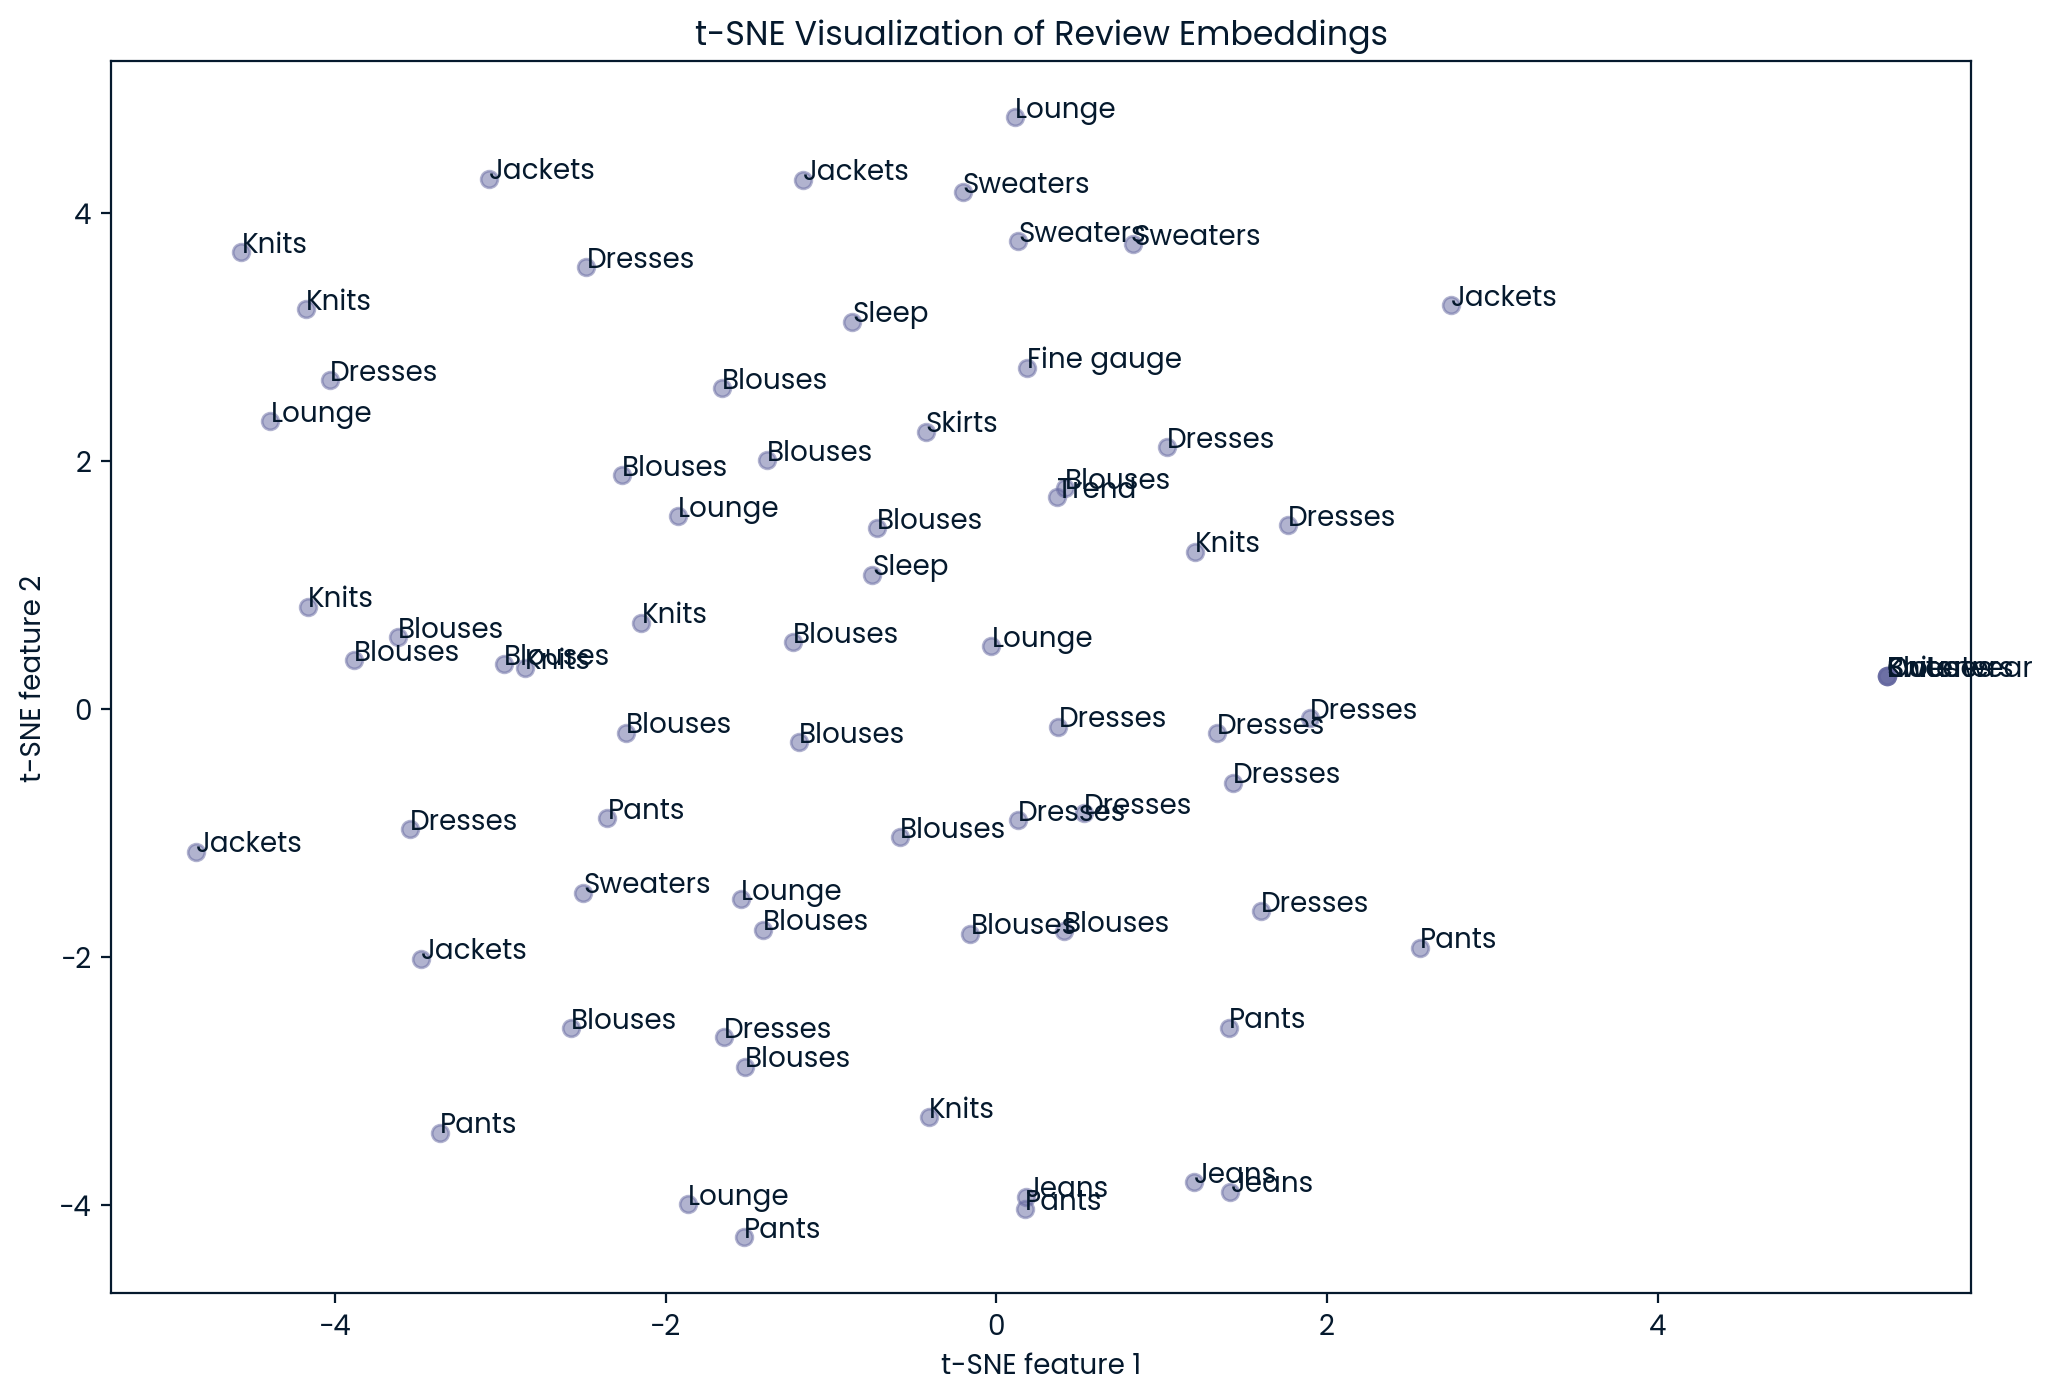

In [4]:
# PART 2: IN THIS SECTION: This is where we can see how similar looking things are grouped together in vectors. 
# We can check this by taking a sample we can visualize, reduce dimension, and plot

import os
from openai import OpenAI
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Count the number of reviews
reviews_cnt = len(reviews['Review Text'])
print(f'''The total number of reviews provided are : {reviews_cnt}''')

# Take sample of reviews to plot
sampled_reviews = reviews.iloc[np.random.randint(low=0, high=1000, size=70)]

# Get all the reviews in a list
reviews_text = [str(review).replace('\n','') for review in sampled_reviews['Review Text']]
sampled_reviews_cnt = len(sampled_reviews['Review Text'])
print(f'''The total number of sampled reviews are : {sampled_reviews_cnt}''')

# Create a client and pass the reviews
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
response = client.embeddings.create(
model="text-embedding-3-small",
input=reviews_text
) 

# Get a response
response_dict = response.model_dump()

# Get the embeddings in a list
embeddings = []
for i in range(sampled_reviews_cnt):
    embeddings.append(response_dict['data'][i]['embedding'])
print(f'''The length of embeddings is: {len(embeddings)}''')


# Use TSNE to reduce dimensionality to 2
def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=0)
    return tsne.fit_transform(embeddings)

# Plotting the results of t-SNE
def plot_tsne(embeddings_2d):
    plt.figure(figsize=(12, 8))
    plt.title("t-SNE Visualization of Review Embeddings")
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
    class_names = [classes for classes in sampled_reviews['Class Name']]
    plt.title("t-SNE Visualization of Review Embeddings")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    for i, classes in enumerate(class_names):
        plt.annotate(classes, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
    plt.show()

embeddings_2d = apply_tsne(np.array(embeddings))
plot_tsne(embeddings_2d)


The total number of reviews provided are : 1000
The unique number of review ids are: 1000
The count of collections is 1000


In [8]:
# PART 3: IN THIS SECTION: Identify 3 reviews that discuss certain topics like - 'quality', 'fit', 'style', 'comfort'

from scipy.spatial import distance

# Get all the reviews in a list
reviews_text = [str(review).replace('\n','') for review in reviews['Review Text']]

def create_embeddings(texts):
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
    response = client.embeddings.create(
    model="text-embedding-3-small",
    input=texts
    ) 
    response_dict = response.model_dump()
    return [data['embedding'] for data in response_dict['data']]

def find_n_closest(query_vector, embeddings, n=3):
    distances = []
    for index, embedding in enumerate(embeddings):
        dist = distance.cosine(query_vector, embedding)
        distances.append({"distance": dist, "index": index})
    distances_sorted = sorted(distances, key=lambda x: x["distance"])
    return distances_sorted[0:n]

topics = [
{'label': 'quality', 'description': 'A review about quality of apparel'},
{'label': 'fit', 'description': 'A review about fit of apparel'},
{'label': 'style', 'description': 'A review about about style of apparel'},
{'label': 'comfort', 'description': 'A review about comfort of apparel'},
]

reviews_embeddings = create_embeddings(reviews_text)

for i,topic in enumerate(topics):
    topic_lbl = topic['label']
    topic_desc = topic['description']
    # topic_descriptions = 
    topic_embeddings = create_embeddings(topic_desc)[0]
    # print(topic_lbl)
    top_reviews = find_n_closest(topic_embeddings, reviews_embeddings)
    for idx, review in enumerate(top_reviews):
        print(f'''Reviews similar to topic '{topic_lbl}' #{idx+1}: {reviews_text[review['index']]} \n''')



Reviews similar to topic 'quality' #1: More and more i find myself reliant on the reviews written by savvy shoppers before me and for the most past, they are right on in their estimation of the product. in the case of this dress-if it had not been for the reveiws-i doubt i would have even tried this. the dress is beautifully made, lined and reminiscent of the old retailer quality. it is lined in the solid periwinkle-colored fabric that matches the outer fabric print. tts and very form-fitting. falls just above the knee and does not rid 

Reviews similar to topic 'quality' #2: It is seldom that i write a review about a tee, but after receiving the jessa tee in the mail today, i just felt compelled to do so! the deal is, this tee is pricey for sure, but in my opinion, it is worth it! as another reviewer said, the cotton fabric is hefty; in fact, it could also be called a "lightweight sweater." everything about this tee is perfect and classic: the elbow sleeves, the nice neckline, and the

In [18]:
# PART 4: IN THIS SECTION: We use a vector DB, ChromaDB to store the vectors and 
# run a search to identify 3 similar reviews, given a review. 

import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# Create a chroma db client
client = chromadb.PersistentClient()

# Create a collection for embedding the reviews
collection = client.get_or_create_collection(
                        name="c_reviews",
                        embedding_function=OpenAIEmbeddingFunction(model_name="text-embedding-3-small", api_key=os.environ["OPENAI_API_KEY"])
)

# Add to the collection
collection.add(ids=ids_list, documents=reviews_text)

# Check the count of collection to ensure it has been created correctly. 
print(f'The count of collections is {collection.count()}')

# Define a function to get a similar review
def get_similar_reviews(search_txt, collection_name,n):
    collection = client.get_collection(
        name=f"{collection_name}",
        embedding_function=OpenAIEmbeddingFunction(model_name="text-embedding-3-small", api_key=os.environ["OPENAI_API_KEY"]))
    results = collection.query(
        query_texts=[search_txt],
        n_results=n)
    return results['documents'][0]
    

search_review = "Absolutely wonderful - silky and sexy and comfortable"
similar_reviews  = get_similar_reviews(search_review, 'c_reviews', 3)
for idx, review in enumerate(similar_reviews):
    print(f'#{idx+1}. {review}')

The count of collections is 1000
#1. Absolutely wonderful - silky and sexy and comfortable
#2. Very comfortable and versatile. got lots of compliments.
#3. This is a very comfortable and sexy sleep dress, the way it drapes. i can see that the type of fabric is not suitable for out and about activities and can catch on snags, etc. very easily. once i relegated it to the nightgown category it became my favorite item to wear and lounge in.


In [20]:
# PART 5: Comparison: Check if the vector db returns similar results as that of the 
# in-memory ones. Results: They are the same. 

for i,topic in enumerate(topics):
    topic_lbl = topic['label']
    topic_desc = topic['description']
    similar_reviews  = get_similar_reviews(topic_desc, 'c_reviews', 3)
    for idx, review in enumerate(similar_reviews):
        print(f'#{idx+1}. {topic_lbl} {review}')

#1. quality More and more i find myself reliant on the reviews written by savvy shoppers before me and for the most past, they are right on in their estimation of the product. in the case of this dress-if it had not been for the reveiws-i doubt i would have even tried this. the dress is beautifully made, lined and reminiscent of the old retailer quality. it is lined in the solid periwinkle-colored fabric that matches the outer fabric print. tts and very form-fitting. falls just above the knee and does not rid
#2. quality It is seldom that i write a review about a tee, but after receiving the jessa tee in the mail today, i just felt compelled to do so! the deal is, this tee is pricey for sure, but in my opinion, it is worth it! as another reviewer said, the cotton fabric is hefty; in fact, it could also be called a "lightweight sweater." everything about this tee is perfect and classic: the elbow sleeves, the nice neckline, and the semi-boxy, semi-cropped fit. it will go with everything

In [21]:
# Clean up
client.delete_collection(name="c_reviews")